# Predicting cryptocurrency prices from Dark Web Transactions

2016 was also a very active year for cryptocurrencies. New cryptocurrencies found use alongside Bitcoin (BTC), with the general offerings of Monero (XMR) seeing a huge surge in popularity. Monero was also known to be a lot more secure than Bitcoin, especially when it came to obfuscation. Since it also does not utilise a public transaction ledger, it supports completely anonymous transactions. Zcash, another privacy-oriented cryptocurrency, had its speculation-hounded debut in 2016. In October, it was sitting on an outrageous valuation of $2M USD, though the following months saw a tumb.

With the current rise in popularity of cryptocurrencies, the aim of our project is to explore if drug sales on the Dark Web can affect the prices of cryptocurrencies. While some analysts have used ARIMA modelling and neural networks to accomplish this task, we will be conducting multivariate time series analysis to formulate models to predict these prices. Specifically, we will predict the 2016 Closing Prices of Bitcoin and Monero using 2016 Dark Web Drug Transactions and subsequently evaluate our models' accuracy.

Code partially adapted from: 
https://towardsdatascience.com/vector-autoregressions-vector-error-correction-multivariate-model-a69daf6ab618

## Load Packages

In [68]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline    

## Import Data

In [69]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

bitcoin = pd.read_csv("bitcoin_price.csv", parse_dates = True, index_col = 1) 
monero = pd.read_csv("monero_price.csv", parse_dates = True, index_col = 0)
drug = pd.read_csv("data_drug.csv", parse_dates = True, index_col = 2) 

## Cleaning

In [70]:
bitcoin = bitcoin.loc["2016-01-01":"2016-12-31"]
bitcoin.index = pd.to_datetime(bitcoin.index.strftime('%Y-%m-%d'))
bitcoin.drop(["Currency", "24h Open (USD)", "24h High (USD)", "24h Low (USD)"],
          axis = 1, inplace = True)
bitcoin_diff = bitcoin.diff().dropna()

monero = pd.read_csv("monero_price.csv", parse_dates = True, index_col = 0)
monero = monero.iloc[::-1]
monero.drop(["Open", "High", "Low", "Vol.", "Change %"],
          axis = 1, inplace = True)
monero_diff = monero.diff().dropna()

drug_daily = drug.drop(["order_id", "item_id", "ships_from", "ships_to", "category"],
          axis = 1, inplace = False)
drug_daily = drug_daily.groupby('date').sum()
drug_daily_diff = drug_daily.diff().dropna()

bitcoin.head()
monero.head()
drug_daily.head()

,Closing Price (USD)
Date,
2016-01-01,432.358
2016-01-02,433.773
2016-01-03,431.985
2016-01-04,431.691
2016-01-05,433.732


,Price
Date,
2016-01-01,0.54
2016-01-02,0.46
2016-01-03,0.49
2016-01-04,0.47
2016-01-05,0.47


,sales
date,
2016-01-01,117015.60
2016-01-02,124689.34
2016-01-03,114559.31
2016-01-04,193617.65
2016-01-05,306290.66


# Exploratory Data Analysis

[Text(0, 0, 'Misc'),
 Text(0, 0, 'Other'),
 Text(0, 0, 'Prescription'),
 Text(0, 0, 'Dissociatives'),
 Text(0, 0, 'Digital Goods'),
 Text(0, 0, 'Psychedelics'),
 Text(0, 0, 'Benzos'),
 Text(0, 0, 'Opioids'),
 Text(0, 0, 'Ecstasy'),
 Text(0, 0, 'Stimulants'),
 Text(0, 0, 'Cannabis')]

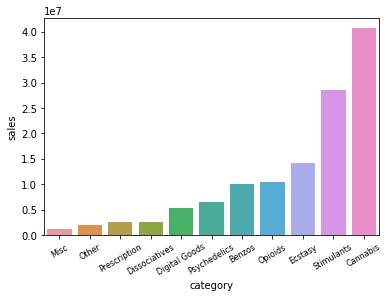

[Text(0, 0, 'Canada'),
 Text(0, 0, ' Worldwide'),
 Text(0, 0, 'United Kingdom'),
 Text(0, 0, 'Australia'),
 Text(0, 0, 'United States')]

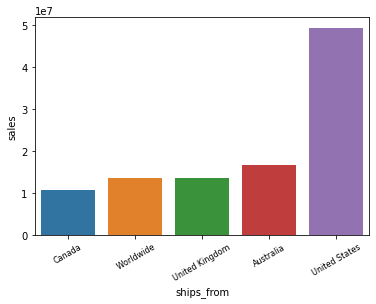

[Text(0, 0, 'North America'),
 Text(0, 0, 'Europe'),
 Text(0, 0, 'Australia'),
 Text(0, 0, 'Worldwide'),
 Text(0, 0, 'United States')]

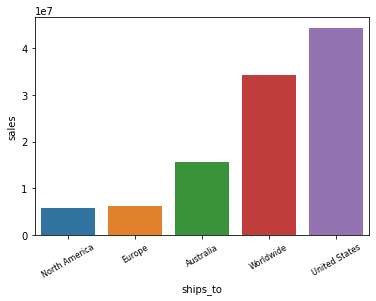

In [71]:
drug_cat = drug.groupby("category").sum()
drug_cat.sort_values(by = ["sales"], inplace = True)

drug_ships_from = drug.groupby("ships_from").sum()
drug_ships_from.sort_values(by = ["sales"], inplace = True)
drug_ships_from = drug_ships_from.tail(5)

drug_ships_to = drug.groupby("ships_to").sum()
drug_ships_to.sort_values(by = ["sales"], inplace = True)
drug_ships_to = drug_ships_to.tail(5)

ax = sns.barplot(x=drug_cat.index, y="sales", data = drug_cat, order = drug_cat.index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
ax.tick_params(axis="x", labelsize=8)
plt.show()

ax2 = sns.barplot(x=drug_ships_from.index, y="sales", data = drug_ships_from, order = drug_ships_from.index)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=30)
ax2.tick_params(axis="x", labelsize=8)
plt.show()

ax3 = sns.barplot(x=drug_ships_to.index, y="sales", data = drug_ships_to, order = drug_ships_to.index)
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=30)
ax3.tick_params(axis="x", labelsize=8)
plt.show()

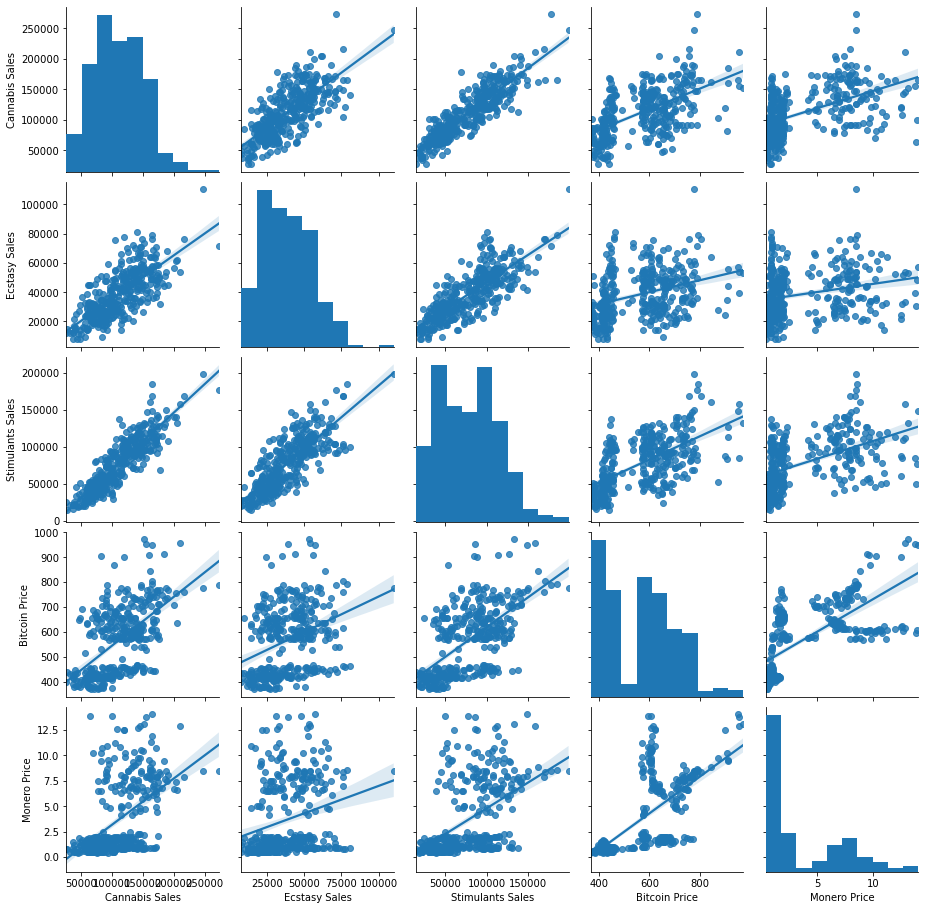

In [72]:
cannabis_daily = drug.loc[drug["category"] == "Cannabis"]
cannabis_daily = cannabis_daily.drop(["category"],
          axis = 1, inplace = False)
cannabis_daily = cannabis_daily.groupby('date').sum()

stimulants_daily = drug.loc[drug["category"] == "Stimulants"]
stimulants_daily = stimulants_daily.drop(["category"],
          axis = 1, inplace = False)
stimulants_daily = stimulants_daily.groupby('date').sum()

ecstasy_daily = drug.loc[drug["category"] == "Ecstasy"]
ecstasy_daily = ecstasy_daily.drop(["category"],
          axis = 1, inplace = False)
ecstasy_daily = ecstasy_daily.groupby('date').sum()

daily_all_variables = pd.DataFrame({"Cannabis Sales" : cannabis_daily["sales"],
                                "Ecstasy Sales" : ecstasy_daily["sales"],
                                "Stimulants Sales" : stimulants_daily["sales"],
                                "Bitcoin Price" : bitcoin["Closing Price (USD)"],
                                "Monero Price" : monero["Price"]})

sns.pairplot(daily_all_variables, kind="reg")
plt.show()

# Vector Autoregressive (VAR) Model 
A Vector Autoregressive model comprises multiple time series. An extension of the auto-regressive (AR) model, it involves multiple independent variables and thus includes multiple equations. All variables in a VAR enter the model in the same way, where each variable has an equation explaining its evolution based on its own lagged values, the lagged values of the other model variables, and an error term. Time series models for VAR are usually based on applying the model to stationary series. We will now create a VAR model using Total Drugs, Bitcoin, Monero (Daily).


## Time Series Plots

We will now plot the time-series of Bitcoin prices, Monero prices and Drug Sales in 2016. 

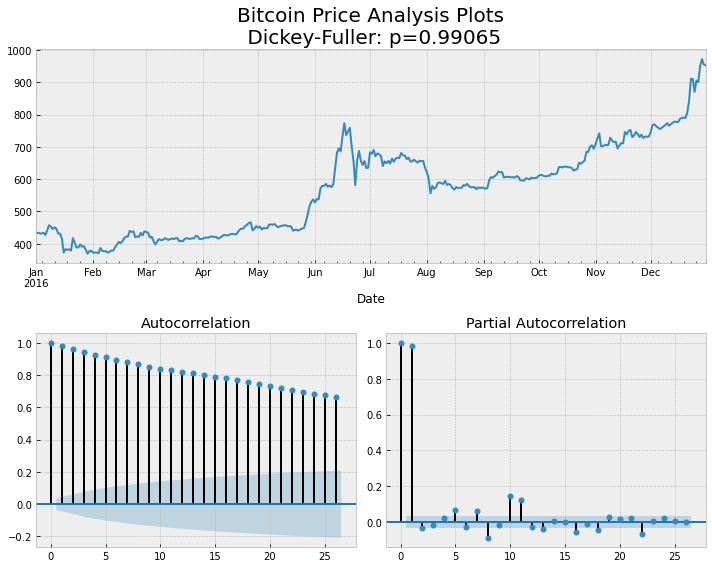

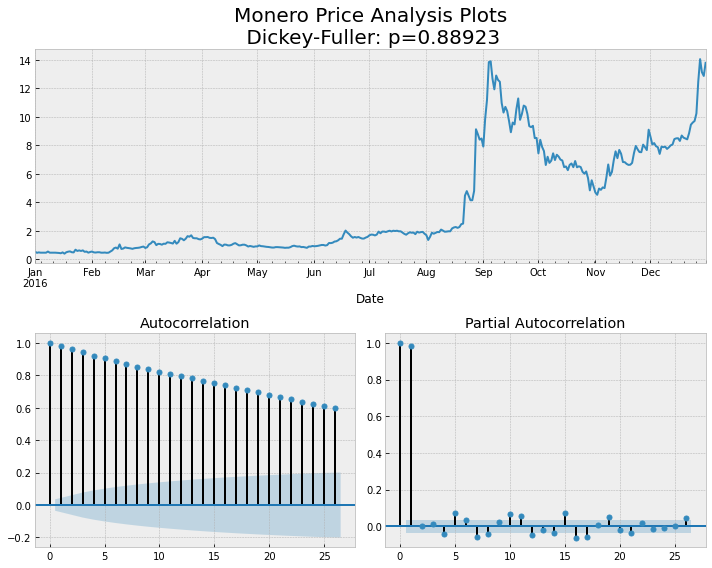

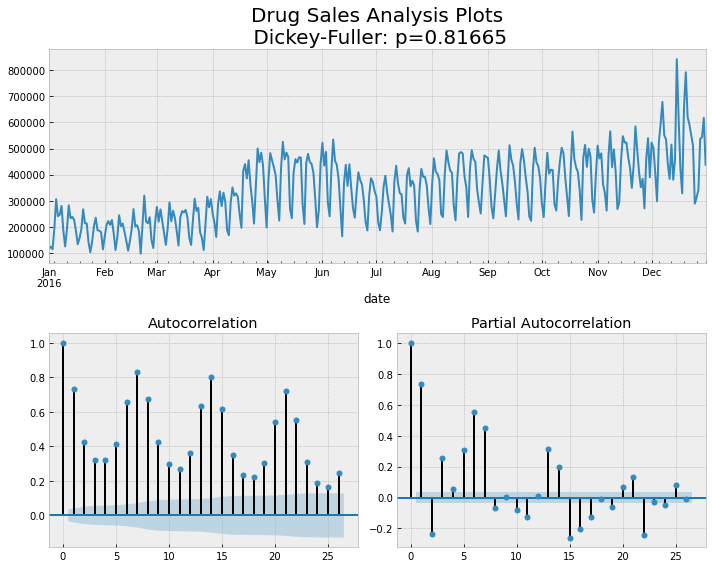

In [73]:
import statsmodels.tsa.api as sm
import statsmodels.tsa.stattools as ts

def tsplot(y, title, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))    
        y.plot(ax=ts_ax)
        p_value = sm.adfuller(y)[1]
        ts_ax.set_title(title + ' Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value), fontsize = 20)
        sm.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        sm.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        plt.tight_layout()
    return


tsplot(bitcoin["Closing Price (USD)"], title = "Bitcoin Price")
tsplot(monero["Price"], title = "Monero Price")
tsplot(drug_daily["sales"], title = "Drug Sales")

We observe some fairly similar trend patterns in our time series which imply that each of the variables might be a linear function of some past values of itself and the past values of the other variables.
The VAR model requires the time series to be stationary, hence we use the ADF test to check for stationarity. By conducting the ADF test on all datasets and plotting out the time series, we find they are not stationary as all of them have a p-value of more than 0.05. 

Results show that all have a p-value of > 0.05. We fail to reject the Null Hypothesis, indicating that the series are non-stationary and contain a unit root. Thus, we difference the data to remove systematic structure from the time series and re-run the ADF test, getting the following results. 

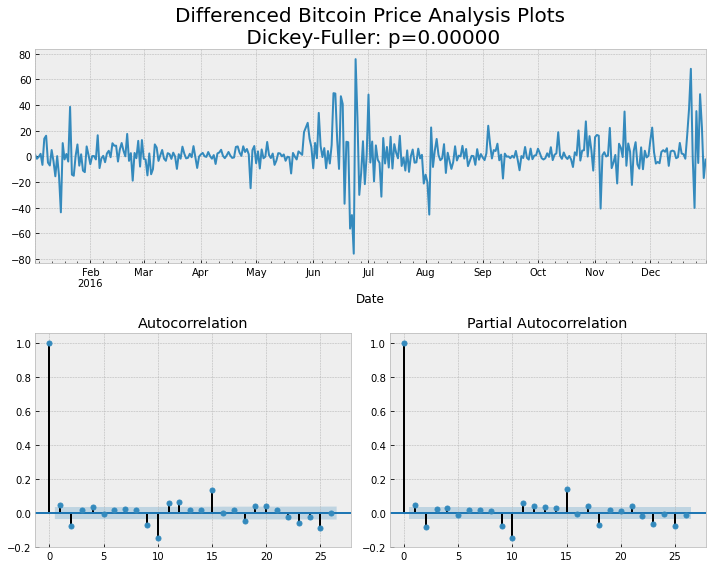

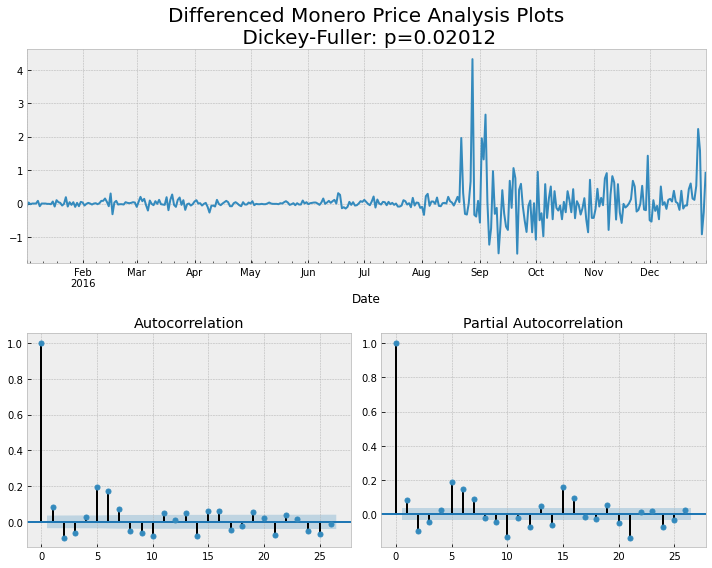

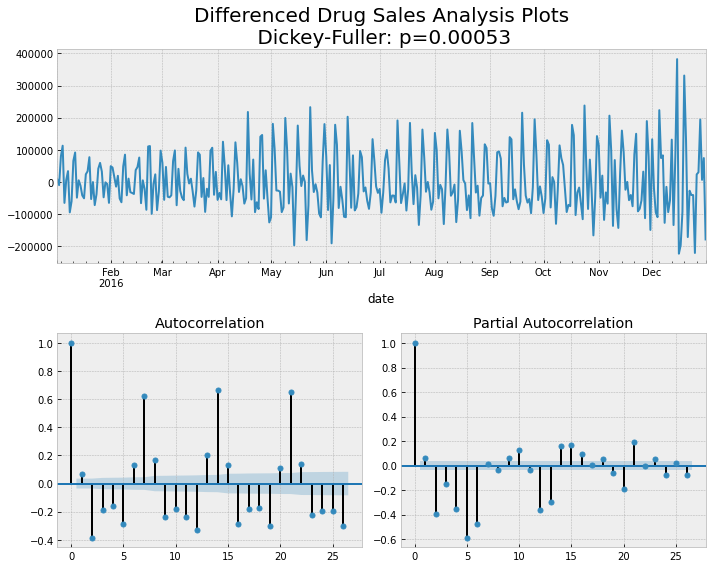

In [74]:
tsplot(bitcoin_diff["Closing Price (USD)"], title = "Differenced Bitcoin Price")
tsplot(monero_diff["Price"], title = "Differenced Monero Price")
tsplot(drug_daily_diff["sales"], title = "Differenced Drug Sales")

Since the differenced variables are stationary, we can now proceed to our VAR modelling.
We obtain the following information criteria for lag orders up to VAR(10).

## Model Determination

In [75]:
from statsmodels.tsa.api import VAR

# Concatenate 3 columns into one dataframe
result = pd.concat([drug_daily_diff, monero_diff["Price"]], axis=1, join='outer', ignore_index=False)
result = pd.concat([result, bitcoin_diff["Closing Price (USD)"]], axis=1, join='outer', ignore_index=False)
result = result.rename(columns={"sales": "Drug_Sales", "Price": "Monero_Price", "Closing Price (USD)": "Bitcoin_Price"})
result.index = pd.DatetimeIndex(result.index.values, freq = result.index.inferred_freq)

# model determination
model = VAR(result)
print(model.select_order(maxlags=10).summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        26.75       26.78   4.132e+11       26.76
1        26.76       26.89   4.179e+11       26.81
2        26.60       26.83   3.583e+11       26.70
3        26.62       26.95   3.652e+11       26.75
4        26.52       26.94   3.286e+11       26.69
5        26.06       26.59   2.084e+11       26.27
6       25.79*      26.42*  1.595e+11*      26.04*
7        25.82       26.54   1.628e+11       26.10
8        25.85       26.67   1.689e+11       26.18
9        25.88       26.80   1.736e+11       26.24
10       25.85       26.86   1.688e+11       26.25
--------------------------------------------------


To select the right order of the VAR model, we iteratively fit increasing orders of the VAR model and pick the order that gives a model with least AIC, BIC, FPE or HQIC values. Should there be a tie, we will use AIC since it gives us less errors in forecasting. In this particular case, values of all parameters show us that lag 6 gives us the best model. Hence, we concluded that the lag order 6 is the most appropriate for this model.

## Model Estimation

In [76]:
results = model.fit(6,trend="nc")
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 11, May, 2020
Time:                     21:09:11
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    26.3589
Nobs:                     359.000    HQIC:                   26.0071
Log likelihood:          -6100.78    FPE:                1.56303e+11
AIC:                      25.7748    Det(Omega_mle):     1.34967e+11
--------------------------------------------------------------------
Results for equation Drug_Sales
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
L1.Drug_Sales           -0.511011         0.047457          -10.768           0.000
L1.Monero_Price      -9832.058367      6867.904053           -1.432           0.152
L1.Bitcoin_Price       -88.989722       210

We observe a relatively weak correlation among the 3 variables. Since the off-diagonal elements of the estimated correlation matrix are not zero, we will therefore investigate further by testing for instantaneous causality between the variables pairwise. This will be done later.

## Model Diagnostics

We conduct a Residual whiteness test using Portmanteau test where H0: The residual autocorrelation up to lag 10 is zero. 

In [77]:
print(results.test_whiteness())
print('\nIs the VAR system is stable? {}'.format(results.is_stable()))
print('\nThe roots are {}'.format(results.roots))

<statsmodels.tsa.vector_ar.hypothesis_test_results.WhitenessTestResults object. H_0: residual autocorrelation up to lag 10 is zero: reject at 5% significance level. Test statistic: 84.714, critical value: 50.998>, p-value: 0.000>

Is the VAR system is stable? True

The roots are [-3.35909527-0.j          0.28371635+2.71440014j  0.28371635-2.71440014j
 -0.74623194+2.27517267j -0.74623194-2.27517267j  1.96378425-0.j
 -1.58069721-0.j         -0.83581573+1.13159994j -0.83581573-1.13159994j
 -1.16847526-0.57766319j -1.16847526+0.57766319j  0.48679283+1.09030098j
  0.48679283-1.09030098j  1.16771402-0.j         -0.21152735+1.06290108j
 -0.21152735-1.06290108j  0.64171747+0.79634882j  0.64171747-0.79634882j]


With p-value < 0.05, we reject the null hypothesis, indicating that at least one series is not white noise. 
We also examine the eigenvalues of the VAR(6) model and observe the roots to be lying outside the unit circle, therefore satisfying the stability condition.
We observe many statistically insignificant independent variables, where at 5% significance level, Drug _Sales is influenced by past values of Drug_Sales, Monero_Price is influenced by past values of Monero_Price, Bitcoin_Price and Drug_Sales while Bitcoin_Price is influenced by past values of Monero_Price.

## Structural Analyses

### Granger Causality

In [78]:
print(results.test_causality('Drug_Sales', ['Bitcoin_Price'],kind='f').summary())
print(results.test_causality('Bitcoin_Price', ['Drug_Sales'],kind='f').summary())
print(results.test_causality('Drug_Sales', ['Monero_Price'],kind='f').summary())
print(results.test_causality('Monero_Price', ['Drug_Sales'],kind='f').summary())

Granger causality F-test. H_0: Bitcoin_Price does not Granger-cause Drug_Sales. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-----------------------------------------------
         1.167          2.107   0.322 (6, 1023)
-----------------------------------------------
Granger causality F-test. H_0: Drug_Sales does not Granger-cause Bitcoin_Price. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-----------------------------------------------
         1.346          2.107   0.234 (6, 1023)
-----------------------------------------------
Granger causality F-test. H_0: Monero_Price does not Granger-cause Drug_Sales. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-----------------------------------------------
        0.6512          2.107   0.689 (6, 1023)
-----------------------------------------------
Granger causal

We observe that the null hypothesis, H0: There is no granger causality, is not rejected between all the variables. Hence there is no granger causation. We now proceed to test instantaneous causality among the variables. The following results were obtained from our R script.

In [79]:
print(results.test_inst_causality('Drug_Sales').summary())
print(results.test_inst_causality('Bitcoin_Price').summary())
print(results.test_inst_causality('Monero_Price').summary())

Instantaneous causality Wald-test. H_0: Drug_Sales does not instantaneously cause [Monero_Price, Bitcoin_Price]. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         5.629          5.991   0.060  2
----------------------------------------
Instantaneous causality Wald-test. H_0: Bitcoin_Price does not instantaneously cause [Drug_Sales, Monero_Price]. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         1.095          5.991   0.578  2
----------------------------------------
Instantaneous causality Wald-test. H_0: Monero_Price does not instantaneously cause [Drug_Sales, Bitcoin_Price]. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         6.660          5.991   0.036  2
----------------------------------------


We observe that the null hypothesis, H0: There is no instantaneous causality, is rejected for Monero Price on Drug Sales and Bitcoin Price. Hence, there is an instantaneous relationship between Monero Price and Drug Sales and Bitcoin Price. Since instantaneous casuality is a symmetric relation, we can consider that there is an instantaneous relationship among all variables.

### Impulse Response Analysis

Our granger causality may not give us the complete story of the interactions between the variables in our system. Therefore, we plot the Impulse Response Functions (IRF) to observe the following impacts on the second variable given a 1-unit shock to the first variable, as well as study the multiplier effects.

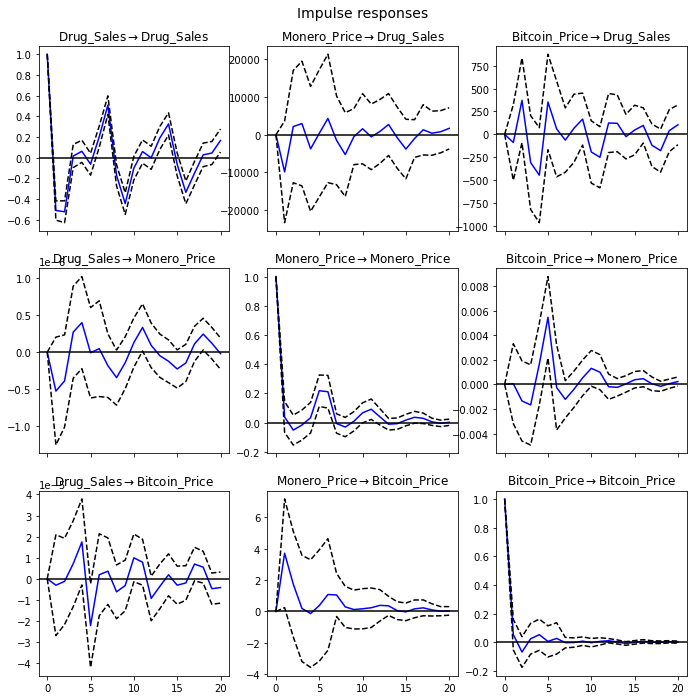

In [80]:
irf = results.irf(20)
irf.plot(orth=False)
plt.close()

For the short term IRF, we observe that:

1. Each variable is unsurprisingly greatly affected by shocks of itself, with a large positive response that decreases to negative quickly and stabilizes at 0.
2. Bitcoin_Price has an insignificant negative response to a shock from Drug_Sales which increases quickly and stabilizes at 0
3. Drug_Sales has a moderate negative response to a shock from Bitcoin_Price which sharply increases to a significant positive response before it stabilizes at 0

Given that there are contemporaneous relations between Drug_Sales and Monero_Price, we need to observe the orthogonalized IRF between these two variables as the orthogonal IRF measures the isolated effect from a shock in one variable to another.

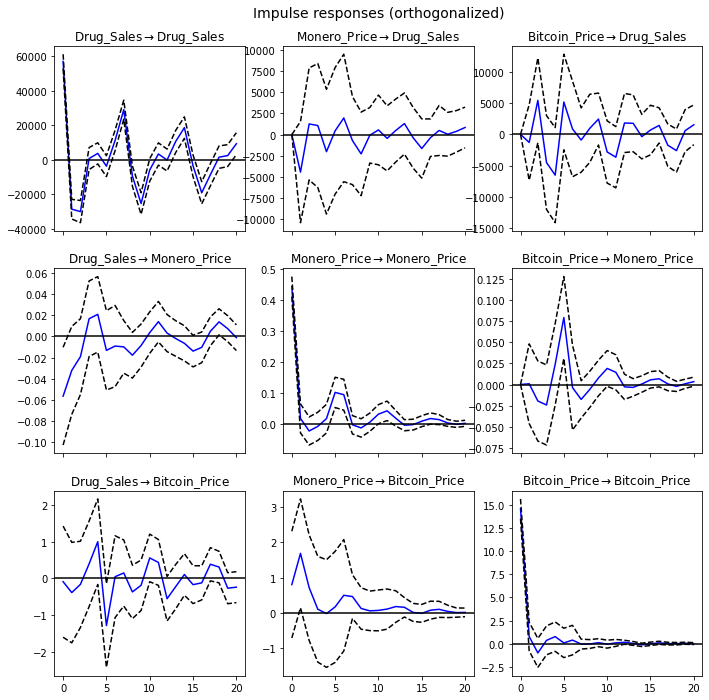

In [81]:
irf.plot(orth=True)
plt.close()

From the short-term orthogonalized IRF, we observe that:

1. Monero_Price has a moderate negative response to a shock from Drug_Sales which quickly increases and stabilizes close to 0. 
2. Drug_Sales has significant negative responses to a shock from Monero_Price before quickly which fluctuates and stabilises with a positive response

As it may be myopic to only observe IRF in the short term, we also plot and observe the cumulative impulse response to observe the long-run effects.

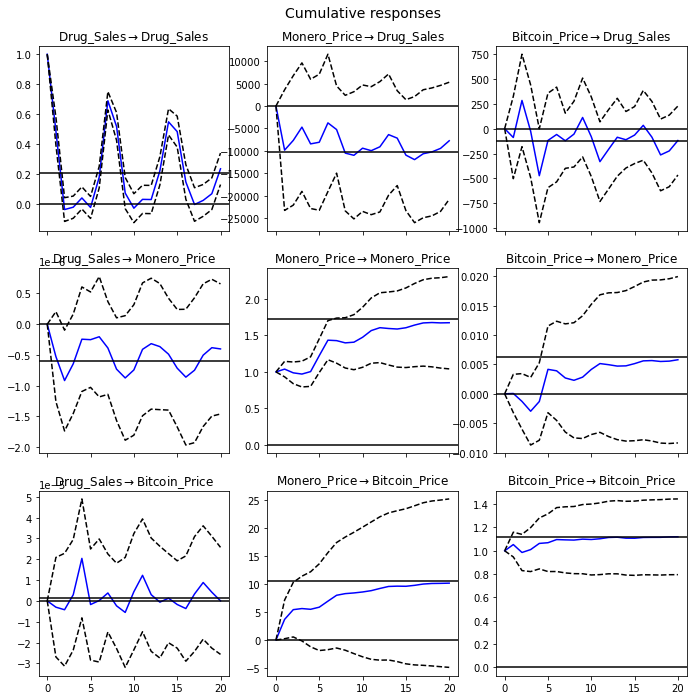

In [82]:
irf.plot_cum_effects(orth=False)
plt.close()

For the long-term IRF, we observe that:

1. Similar to the short term IRFs, the long term IRF shows that variables respond positively to shocks from itself. However in the long term, instead of stabilizing at 0, all 3 variables reach some sustained positive response to shocks from itself.
2. Bitcoin_Price has an insignificant response to a shock from Drug_Sales which fluctuates minimally and stabilizes close to 0.
3. Drug_Sales has a sharp initial positive response to shocks from Bitcoin_Price before gradually decreasing to some sustained negative response.

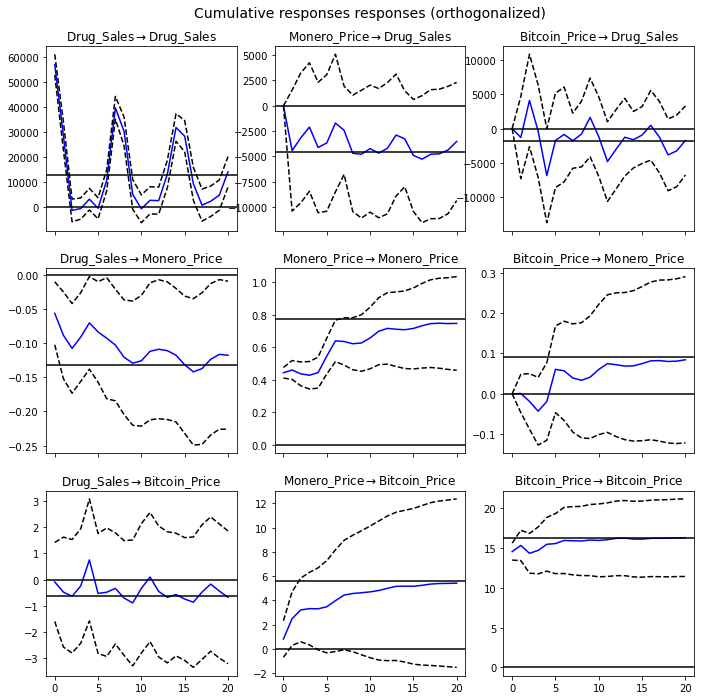

In [83]:
irf.plot_cum_effects(orth=True)
plt.close()

From the long-term orthogonalized IRF, we observe that:
    
1. Monero_Price has an insignificant negative response to a shock from Drug_Sales which gradually increases and stabilizes around 0. 
2. Drug_Sales has an initial significant negative response to a shock from Monero_Price which gradually increases and stabilises at some positive response.

### Forecast Error Variance Decomposition

The forecast error variance decomposition (FEVD) measures the fraction of the forecast error variance of a variable that can be attributed to another variable.

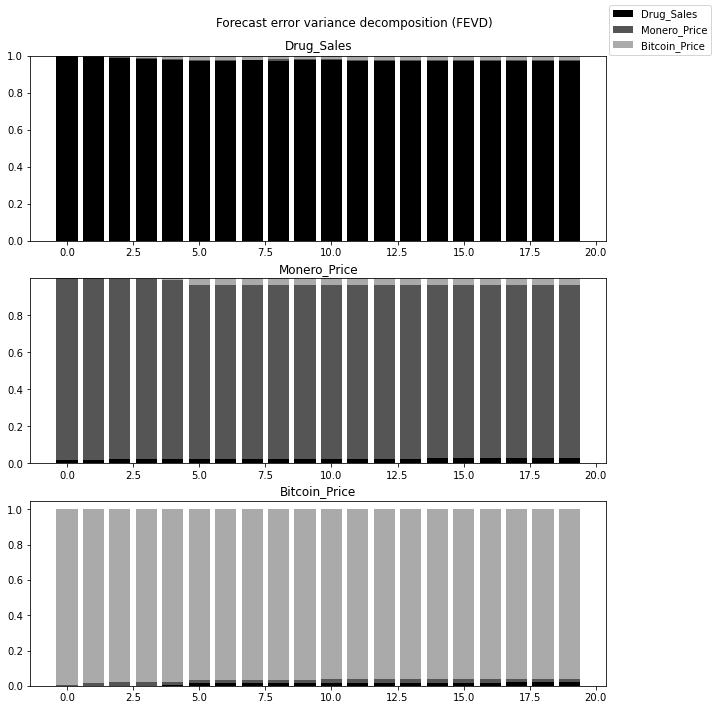

In [84]:
fevd = results.fevd(5)
results.fevd(20).plot()
plt.close()

In this FEVD, we observe that:

1. Prediction of Drug_sales is largely determined by Drug_sales shocks and minimally affected by Bitcoin_Price
2. Prediction of Monero_price is largely determined by Monero_price shocks, with some small influence from Drug_sales and Bitcoin_Price
3. Prediction  of Bitcoin_Priceis largely largely determined by Bitcoin_Price shocks, with some small influence from Drug_sales and Monero_Price
4. The variance in the forecast error of all the variables is mainly explained by the variable alone, i.e, the orthogonal shocks to other variables in the system do not increase the variance of your forecast error. These findings are relatively consistent with both our observations from our short term/long-term impulse response functions and granger causality tests.

# Vector Error Cointegration Model 

While VAR models are useful for multivariate series analysis, differencing the series to make them stationary comes at a cost of ignoring “long run” relationships between levels. Hence, an alternative would be to implement a Vector Error Cointegration Model (VECM), which combines levels and differences. Before we implement this model, we need to test whether the level regressions are cointegrated using Johansen’s Test.

## Model Determination

In order to conduct Johansen’s Cointegration Test, we must first determine the number of lags. We get the number of lags based on the information criteria of our VAR model.

In [85]:
daily_drug_bitcoin = pd.DataFrame({"Drug_Sales" : drug_daily["sales"], 
                         "Bitcoin_Price" : bitcoin["Closing Price (USD)"]})
daily_drug_bitcoin.index = pd.DatetimeIndex(daily_drug_bitcoin.index.values, freq = daily_drug_bitcoin.index.inferred_freq)

daily_drug_monero = pd.DataFrame({"Drug_Sales" : drug_daily["sales"], 
                         "Monero_Price" : monero["Price"]})
daily_drug_monero.index = pd.DatetimeIndex(daily_drug_monero.index.values, freq = daily_drug_monero.index.inferred_freq)

model = VAR(daily_drug_bitcoin)
model2 = VAR(daily_drug_monero)

print("Drug Sales and Bitcoin Price\n")
print(model.select_order(maxlags=10).summary())
print("\n ")
print("Drug Sales and Monero Price \n")
print(model2.select_order(maxlags=10).summary())

Drug Sales and Bitcoin Price

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        32.96       32.98   2.058e+14       32.97
1        28.04       28.11   1.510e+12       28.07
2        27.93       28.04   1.352e+12       27.98
3        27.91       28.07   1.326e+12       27.97
4        27.93       28.13   1.353e+12       28.01
5        27.90       28.13   1.302e+12       27.99
6        27.55       27.83   9.222e+11       27.66
7       27.31*      27.64*  7.285e+11*      27.44*
8        27.32       27.69   7.297e+11       27.46
9        27.33       27.74   7.408e+11       27.50
10       27.33       27.79   7.437e+11       27.52
--------------------------------------------------

 
Drug Sales and Monero Price 

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        25.83     

We can see that lag order 7 gives us the best model for Drug Sales and Bitcoin Price, while lag order 8 gives us the best model for Drug Sales and Monero Price. 

## Johansen's Cointegration Test

We can now proceed with Johansen's Cointegration Test with no deterministic terms in both systems.

In [86]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def print_coint_results(coint_results):
    print ('--------------------------------------------------')
    print ('--> Trace Statistics')
    print ('variable statistic Crit-90% Crit-95%  Crit-99%')
    for i in range(len(coint_results.lr1)):
        print ('r =', i, '\t', round(coint_results.lr1[i], 4), coint_results.cvt[i, 0], coint_results.cvt[i, 1], coint_results.cvt[i, 2])
    print ('--------------------------------------------------')

print("Drug Sales and Bitcoin Price")
coint_results = coint_johansen(daily_drug_bitcoin, det_order=-1, k_ar_diff=7)
print_coint_results(coint_results)

print("\n\nDrug Sales and Monero Price")
coint_results2 = coint_johansen(daily_drug_monero, det_order=-1, k_ar_diff=8)
print_coint_results(coint_results2)

Drug Sales and Bitcoin Price
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 14.2565 10.4741 12.3212 16.364
r = 1 	 1.1858 2.9762 4.1296 6.9406
--------------------------------------------------


Drug Sales and Monero Price
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 6.6159 10.4741 12.3212 16.364
r = 1 	 0.2851 2.9762 4.1296 6.9406
--------------------------------------------------


For Drug Sales and Bitcoin Price, the trace statistics tell us whether the sum of the eigenvalues is 0. The null hypothesis, r=0 gives us a trace statistic of 14.2565, hence the null hypothesis can be rejected at a 95% confidence level, as the magnitude of the trace statistic is greater than the critical value. We can conclude that there is at least one cointegrating vector in the system. Therefore, we can model a VECM for Drug_Sales and Bitcoin_Price.

For Drug Sales and Monero Price, we fail to reject the null hypothesis. There is no cointegration in this system.

## Model Estimation

We will now create a VECM model for Drug_Sales and Bitcoin_Price with 7 lags, 1 cointegrating relationship and a constant and a linear trend outside the cointegration relation.

In [87]:
from statsmodels.tsa.vector_ar.vecm import VECM

vecm_model = VECM(endog = daily_drug_bitcoin, k_ar_diff = 7, coint_rank = 1, deterministic = 'colo')
vecm_fit = vecm_model.fit()
vecm_fit.summary()

,coef,std err,z,P>|z|,[0.025,0.975]
const,7.932e+04,2.37e+04,3.349,0.001,3.29e+04,1.26e+05
lin_trend,277.6439,88.193,3.148,0.002,104.788,450.500
L1.Drug_Sales,-0.3340,0.070,-4.778,0.000,-0.471,-0.197
L1.Bitcoin_Price,-50.7290,205.562,-0.247,0.805,-453.623,352.165
L2.Drug_Sales,-0.6197,0.066,-9.361,0.000,-0.749,-0.490
L2.Bitcoin_Price,425.7747,206.385,2.063,0.039,21.268,830.281
L3.Drug_Sales,-0.5207,0.065,-8.039,0.000,-0.648,-0.394
L3.Bitcoin_Price,-177.5570,207.313,-0.856,0.392,-583.883,228.769
L4.Drug_Sales,-0.5671,0.060,-9.383,0.000,-0.686,-0.449
L4.Bitcoin_Price,-255.5650,209.352,-1.221,0.222,-665.887,154.757


## Model Diagnostics

In [88]:
print(vecm_fit.test_whiteness())

<statsmodels.tsa.vector_ar.hypothesis_test_results.WhitenessTestResults object. H_0: residual autocorrelation up to lag 10 is zero: reject at 5% significance level. Test statistic: 56.382, critical value: 18.307>, p-value: 0.000>


With p-value < 0.05, we reject the null hypothesis, indicating that at least one series is not white noise. We also examine the eigenvalues of the VECM model and observe the roots to be lying outside the unit circle, therefore satisfying the stability condition.

# Forecasting

Having understood the methodology to determine a VAR and VECM model, we shall now use them to forecast Bitcoin Price using Drug Sales. We first fit the respective models onto the relevant datasets, where we split it into training and validation data using a 70-30 ratio. The training data, which dates from 1 January 2016 to 12 September 2016, will be used to forecast values that will be compared against the actual values present in the validation data, which dates from 13 September 2016 to 31 December 2016. Then, we will evaluate the models’ accuracy. 

In [89]:
train_size = int(len(daily_drug_bitcoin) * 0.7)
x_train, x_validation = daily_drug_bitcoin[0:train_size], daily_drug_bitcoin[train_size:]
t = x_train.diff().dropna()

## VAR 

For forecasting using a VAR model, it is important to note that we have used differenced values. Hence, we need to de-difference the data in order to return to its original scale. We have rectified this problem by taking the cumulative sum of our differenced data to produce the following forecast:

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        28.02       28.05   1.477e+12       28.03
1        28.03       28.11   1.485e+12       28.06
2        27.83       27.97   1.222e+12       27.89
3        27.82       28.02   1.211e+12       27.90
4        27.60       27.86   9.720e+11       27.71
5        27.01       27.33   5.401e+11       27.14
6        26.56      26.94*   3.444e+11      26.71*
7        26.56       26.99   3.415e+11       26.73
8       26.53*       27.01  3.317e+11*       26.72
9        26.54       27.09   3.375e+11       26.76
10       26.54       27.14   3.378e+11       26.79
--------------------------------------------------


<Figure size 864x360 with 0 Axes>

Text(0.5, 0, 'Date')

Text(0.5, 1.0, 'Predicted vs Actual Price')

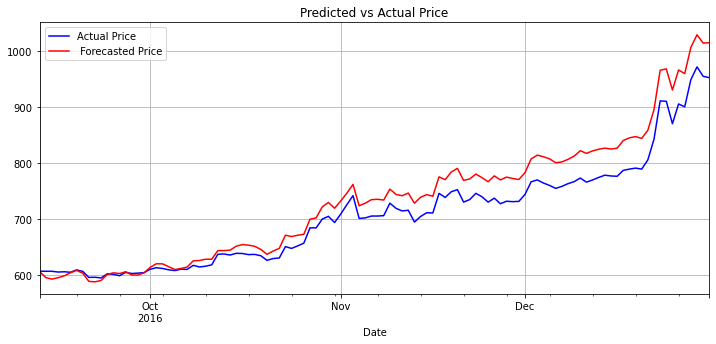

In [101]:
model = VAR(t)
print(model.select_order(maxlags=10).summary())
results = model.fit(8)
lag_order = results.k_ar
var_pred = results.forecast(t.values[-lag_order:], len(x_validation))
var_pred_df =pd.DataFrame(var_pred, index=daily_drug_bitcoin.index[-len(x_validation):], columns=daily_drug_bitcoin.columns)

var_pred_inverse = var_pred_df.cumsum()
var_forecast = pred_inverse + x_validation

forecast_errors = [x_validation.Bitcoin_Price[i] - var_forecast.Bitcoin_Price[i] for i in range(len(x_validation))]

plt.figure(figsize=(12,5))
plt.xlabel('Date')
ax1 = x_validation.Bitcoin_Price.plot(color = 'blue', grid = True, label = 'Actual Price')
ax2 = var_forecast.Bitcoin_Price.plot(color = 'red', grid = True, label = ' Forecasted Price')
ax1.legend(loc=1)
ax2.legend(loc=2)
plt.title('Predicted vs Actual Price')
plt.show()

## VECM

<Figure size 864x360 with 0 Axes>

Text(0.5, 0, 'Date')

Text(0.5, 1.0, 'Predicted vs Actual Price')

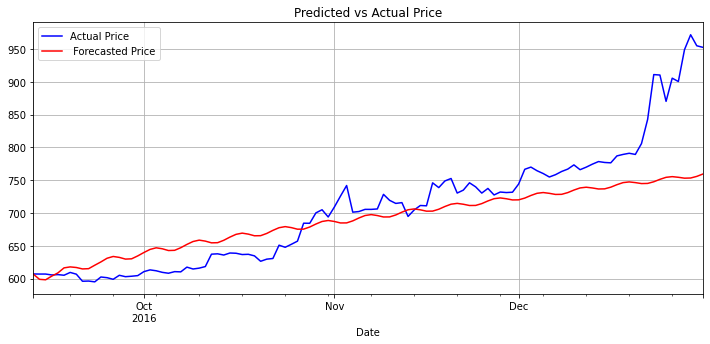

In [102]:
####### FORECAST ##########
vecm_model = VECM(endog = x_train, k_ar_diff = 8, coint_rank = 1, deterministic = 'colo')
vecm_fit = vecm_model.fit()

#vecm_fit.predict(steps= len(x_validation)
forecast, lower, upper = vecm_fit.predict(len(x_validation), 0.05)
vecm_forecast =pd.DataFrame(forecast, index=daily_drug_bitcoin.index[-len(x_validation):], 
                          columns = daily_drug_bitcoin.columns)


plt.figure(figsize=(12,5))
plt.xlabel('Date')
ax1 = x_validation.Bitcoin_Price.plot(color = 'blue', grid = True, label = 'Actual Price')
ax2 = vecm_forecast.Bitcoin_Price.plot(color = 'red', grid = True, label = ' Forecasted Price')
ax1.legend(loc=1)
ax2.legend(loc=2)
plt.title('Predicted vs Actual Price')
plt.show()

### Forecast Evaluation

In [103]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import math

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


print("VAR Forecast Evaluation")
forecast_errors = [x_validation.Bitcoin_Price[i]-var_forecast.Bitcoin_Price[i] for i in range(len(x_validation))]
bias = sum(forecast_errors) * 1.0/len(x_validation)
print('Bias: %f' % bias)
mae = mean_absolute_error(x_validation.Bitcoin_Price, var_forecast.Bitcoin_Price)
print('Mean absolute error (MAE): %f' % mae)
mse = mean_squared_error(x_validation.Bitcoin_Price, var_forecast.Bitcoin_Price)
print('Mean squared error (MSE): %f' % mse)
mape = mean_absolute_percentage_error(x_validation.Bitcoin_Price, var_forecast.Bitcoin_Price)
print('Mean absolute percentage error (MAPE): %f' % mape)
rmse = math.sqrt(mse)
print('Root Mean squared error (RMSE): %f' % rmse)

print("\nVECM Forecast Evaluation")
forecast_errors = [x_validation.Bitcoin_Price[i] - vecm_forecast.Bitcoin_Price[i] for i in range(len(x_validation))]
bias = sum(forecast_errors) * 1.0/len(x_validation)
print('Bias: %f' % bias)
mae = mean_absolute_error(x_validation.Bitcoin_Price, vecm_forecast.Bitcoin_Price)
print('Mean absolute error (MAE):  %f' % mae)
mse = mean_squared_error(x_validation.Bitcoin_Price, vecm_forecast.Bitcoin_Price)
print('Mean squared error (MSE):  %f' % mse)
rmse = math.sqrt(mse)
print('Root Mean squared error (RMSE): %f' % rmse)

VAR Forecast Evaluation
Bias: -26.174101
Mean absolute error (MAE): 27.558742
Mean squared error (MSE): 1112.841283
Mean absolute percentage error (MAPE): 3.647690
Root Mean squared error (RMSE): 33.359276

VECM Forecast Evaluation
Bias: 17.965063
Mean absolute error (MAE):  38.418341
Mean squared error (MSE):  3329.488780
Root Mean squared error (RMSE): 57.701723


We can see that our VAR forecast is more accurate based on RMSE. While the VAR Model's bias is more negative as it consistently forecasts prices lower than actual, it is able to forecast the trend of actual prices more accurately. For our VECM forecast, the model fails to predict the sharp increase in prices at the end of December. Hence, VAR is the better model for predicting daily Bitcoin Prices using Total Drug sales.



# Exploring Further Relationships

We have successfully concluded that daily Drug Sales may be used to predict Bitcoin Price using a VAR model. However, this may not be the best model, and we can enrich our analyses by using different models with different permutations categorised by total drugs, cannabis, stimulants or ecstasy, aggregated over daily, weekly and biweekly time periods. 

In [105]:
# Aggregate data over weekly and biweekly time periods

drug_weekly = drug_daily.resample('W-FRI').sum()
bitcoin_weekly = bitcoin.resample('W-FRI').last()
monero_weekly = monero.resample('W-FRI').last()
cannabis_weekly = cannabis_daily.resample('W-FRI').sum()
stimulants_weekly = stimulants_daily.resample('W-FRI').sum()
ecstasy_weekly = ecstasy_daily.resample('W-FRI').sum()

drug_weekly = drug_weekly.head(-1)
bitcoin_weekly = bitcoin_weekly.head(-1)
monero_weekly = monero_weekly.head(-1)
cannabis_weekly = cannabis_weekly.head(-1)
stimulants_weekly = stimulants_weekly.head(-1)
ecstasy_weekly = ecstasy_weekly.head(-1)

drug_biweekly = drug_daily.resample('2W-FRI').sum()
bitcoin_biweekly = bitcoin.resample('2W-FRI').last()
monero_biweekly = monero.resample('2W-FRI').last()
cannabis_biweekly = cannabis_daily.resample('2W-FRI').sum()
stimulants_biweekly = stimulants_daily.resample('2W-FRI').sum()
ecstasy_biweekly = ecstasy_daily.resample('2W-FRI').sum()

drug_biweekly = drug_biweekly.head(-1)
bitcoin_biweekly = bitcoin_biweekly.head(-1)
monero_biweekly = monero_biweekly.head(-1)
cannabis_biweekly = cannabis_biweekly.head(-1)
stimulants_biweekly = stimulants_biweekly.head(-1)
ecstasy_biweekly = ecstasy_biweekly.head(-1)

To find the most ideal variables, we have decided to use Granger Causality to identify them. 
As Granger Causality is a statistical hypothesis test that is more easily quantifiable compared to Impulse Response Analysis and FEVD, we will use this metric to determine which variables are more suitable to be used to forecast our crypto-currency prices. In particular, we create 3 matrices with multiple permutations categorised by total drugs, cannabis, stimulants or ecstasy, aggregated over daily, weekly and biweekly time periods. 
The results of Granger-causality p-values are summarised in the following matrices.

(*Calculation of p-values follows the same procedure as section 3.5.1. Code has been ommited as it is repetitive) 


![Daily](matrices/1.png "Daily")

![Weekly](matrices/2_1.png "Weekly")

![Biweekly](matrices/2_2.png "Biweekly")


We can see that there are five p-values less than 0.05. Hence we can conclude that:

For the Daily time period: 
- Stimulant sales granger causes Monero Price 
- Ecstasy sales granger causes Monero Price. 

For the Weekly time period: 
- Total Drug sales granger causes Bitcoin price
- Cannabis sales granger causes Bitcoin price
- Ecstasy sales granger causes Bitcoin price. 

We do not observe any granger causality of our any type of drug sales on cryptocurrency prices for the Biweekly category.

We can now proceed with forecasting for the 5 relationships mentioned earlier by building the relevant models here. 
Using the same methodology to forecast daily Bitcoin Price using overall Drug Sales, we will split our data into training and testing using a 70-30 ratio and forecast crypto-currency prices for 13 September 2016 to 31 December 2016. After which, we will evaluate the various models’ accuracy using various error metrics as shown below.

## Forecasting

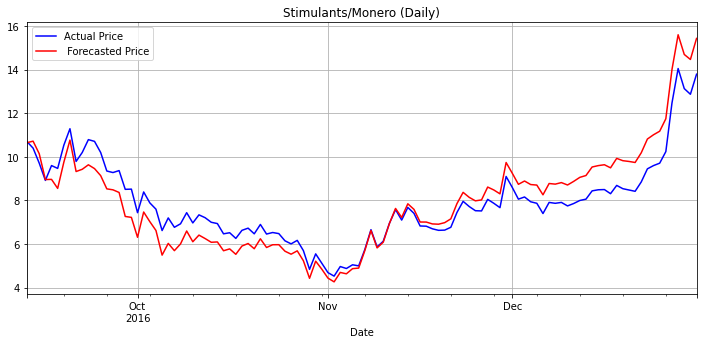

Bias: -0.056129
Mean absolute error (MAE):  0.735656
Mean absolute percentage error (MAPE): 9.009300
Mean squared error (MSE):  0.722865
Root Mean squared error (RMSE): 0.850215


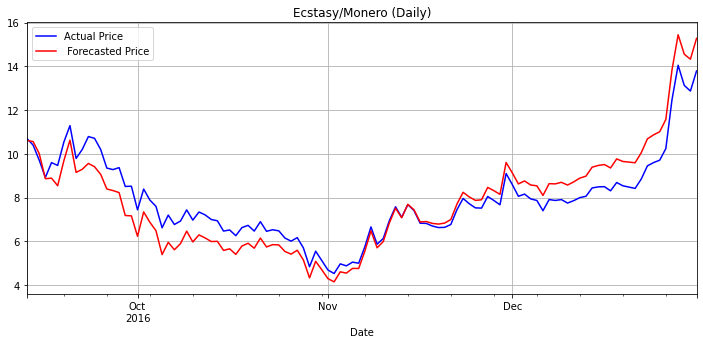

Bias: 0.068619
Mean absolute error (MAE):  0.726725
Mean absolute percentage error (MAPE): 9.063738
Mean squared error (MSE):  0.693716
Root Mean squared error (RMSE): 0.832896


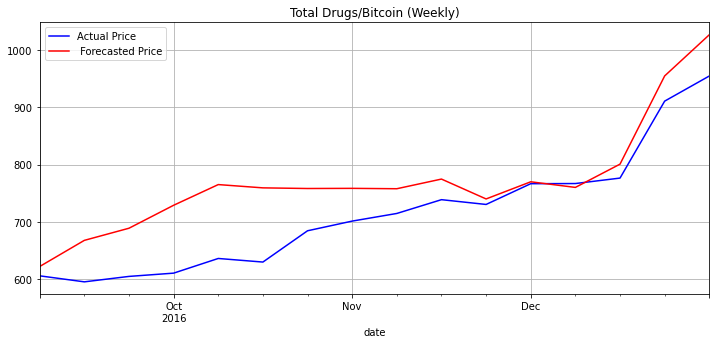

Bias: -56.729903
Mean absolute error (MAE):  57.575454
Mean absolute percentage error (MAPE): 8.576150
Mean squared error (MSE):  4999.262446
Root Mean squared error (RMSE): 70.705463


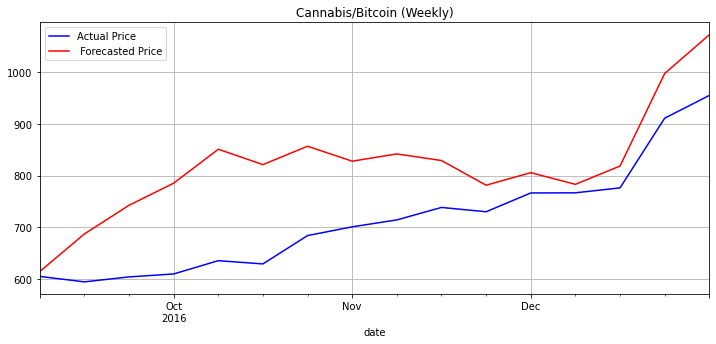

Bias: -105.728279
Mean absolute error (MAE):  105.728279
Mean absolute percentage error (MAPE): 15.483688
Mean squared error (MSE):  14943.611424
Root Mean squared error (RMSE): 122.244065


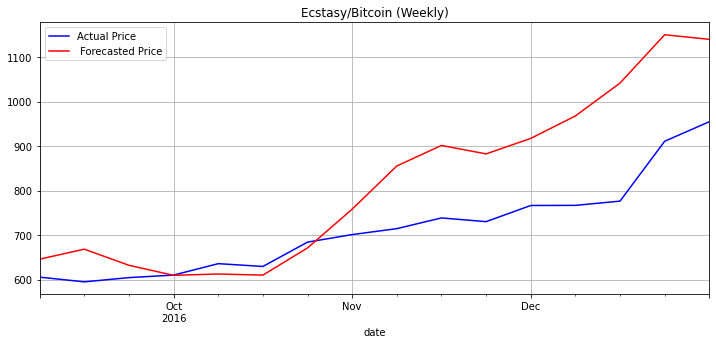

Bias: -102.496306
Mean absolute error (MAE):  109.535784
Mean absolute percentage error (MAPE): 14.301043
Mean squared error (MSE):  19172.978498
Root Mean squared error (RMSE): 138.466525


In [123]:
#Concatenate relevant columns into one dataframe
stimulants_monero_f = pd.concat([stimulants_daily, monero["Price"]], axis=1, join='outer', ignore_index=False)
stimulants_monero_f.index = pd.DatetimeIndex(stimulants_monero_f.index.values, freq = stimulants_monero_f.index.inferred_freq)

ecstasy_monero_f = pd.concat([ecstasy_daily, monero["Price"]], axis=1, join='outer', ignore_index=False)
ecstasy_monero_f.index = pd.DatetimeIndex(ecstasy_monero_f.index.values, freq = ecstasy_monero_f.index.inferred_freq)

drugs_bitcoin_f = pd.concat([drug_weekly, bitcoin_weekly["Closing Price (USD)"]], axis=1, join='outer', ignore_index=False)
drugs_bitcoin_f = drugs_bitcoin_f.rename(columns={"Closing Price (USD)": "Price"})

cannabis_bitcoin_f = pd.concat([cannabis_weekly, bitcoin_weekly["Closing Price (USD)"]], axis=1, join='outer', ignore_index=False)
cannabis_bitcoin_f = cannabis_bitcoin_f.rename(columns={"Closing Price (USD)": "Price"})

ecstasy_bitcoin_f = pd.concat([ecstasy_weekly, bitcoin_weekly["Closing Price (USD)"]], axis=1, join='outer', ignore_index=False)
ecstasy_bitcoin_f = ecstasy_bitcoin_f.rename(columns={"Closing Price (USD)": "Price"})

dfs = [stimulants_monero_f, ecstasy_monero_f, drugs_bitcoin_f, cannabis_bitcoin_f, ecstasy_bitcoin_f]
orders = [6, 6, 9, 9, 10]
names = ["Stimulants/Monero (Daily)", "Ecstasy/Monero (Daily)", "Total Drugs/Bitcoin (Weekly)"
             ,"Cannabis/Bitcoin (Weekly)", "Ecstasy/Bitcoin (Weekly)"]

def forecast_plot(df, order, names):
    train_size = int(len(df) * 0.70)
    x_train, x_validation = df[0:train_size], df[train_size:]
    t = x_train.diff().dropna()
    model = VAR(t)
    # print(model.select_order(maxlags=10).summary())
    results = model.fit(order)
    lag_order = results.k_ar
    pred = results.forecast(t.values[-lag_order:], len(x_validation))
    pred_df =pd.DataFrame(pred, index=df.index[-len(x_validation):], columns=df.columns)

    pred_inverse = pred_df.cumsum()
    f = pred_inverse + x_validation
    forecast_errors = [x_validation.Price[i]-f.Price[i] for i in range(len(x_validation))]

    plt.figure(figsize=(12,5))
    plt.xlabel('Date')
    ax1 = x_validation.Price.plot(color = 'blue', grid = True, label = 'Actual Price')
    ax2 = f.Price.plot(color = 'red', grid = True, label = ' Forecasted Price')
    ax1.legend(loc=1)
    ax2.legend(loc=2)
    plt.title(names)
    plt.show()

    bias = sum(forecast_errors) * 1.0/len(x_validation)
    print('Bias: %f' % bias)
    mae = mean_absolute_error(x_validation.Price, f.Price)
    print('Mean absolute error (MAE):  %f' % mae)
    mape = mean_absolute_percentage_error(x_validation.Price, f.Price)
    print('Mean absolute percentage error (MAPE): %f' % mape)
    mse = mean_squared_error(x_validation.Price, f.Price)
    print('Mean squared error (MSE):  %f' % mse)
    rmse = math.sqrt(mse)
    print('Root Mean squared error (RMSE): %f' % rmse)
    
    return


for df, order, name in zip(dfs, orders, names):
    forecast_plot(df, order, name)

Looking at the summarised error metrics of the models used for daily data, our most accurate models are Stimulants and Monero, and Ecstasy and Monero. We will use these 2 models to predict January to March 2017 Monero prices and compare them against our test set of actual Monero prices. For weekly data, our models exhibit poor accuracy and thus will be ignored. 

<Figure size 864x360 with 0 Axes>

Text(0.5, 0, 'Date')

Text(0.5, 1.0, '2017 January to March (Stimulants/Monero)')

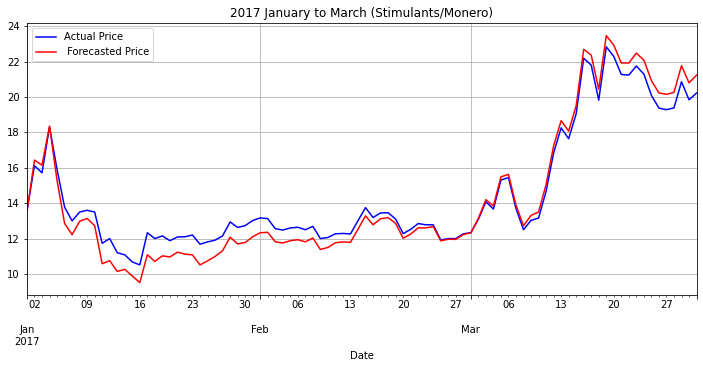

Bias: 0.229223
Mean absolute error (MAE):  0.601310
Mean absolute percentage error (MAPE): 4.349019
Mean squared error (MSE):  0.476849
Root Mean squared error (RMSE): 0.690543


<Figure size 864x360 with 0 Axes>

Text(0.5, 0, 'Date')

Text(0.5, 1.0, '2017 January to March (Stimulants/Monero)')

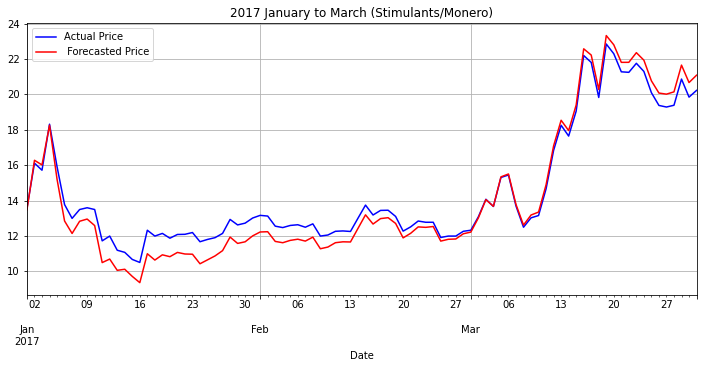

Bias: 0.347943
Mean absolute error (MAE):  0.624146
Mean absolute percentage error (MAPE): 4.643389
Mean squared error (MSE):  0.526663
Root Mean squared error (RMSE): 0.725715


In [143]:
#Import Monero_2017 data
monero_2017 = pd.read_csv("monero_price.csv", parse_dates = True, index_col = 0)
monero_2017 = monero_2017.iloc[::-1]
monero_2017.drop(["Open", "High", "Low", "Vol.", "Change %"],
          axis = 1, inplace = True)
monero_2017 = monero_2017.loc["2017-01-01":"2017-03-31"]

#Forecasting 2017 January Monero prices using Stimulants
train_size = int(len(stimulants_monero_f) * 0.70)
x_train, x_test = stimulants_monero_f[0:train_size], stimulants_monero_f[train_size:]
t = x_train.diff().dropna()
model = VAR(t)
results = model.fit(order)
lag_order = results.k_ar
pred = results.forecast(t.values[lag_order:], len(monero_2017))
pred_df =pd.DataFrame(pred, index=monero_2017.index[-len(monero_2017):], columns=stimulants_monero_f.columns)

pred_inverse = pred_df.cumsum()
f = pred_inverse + monero_2017
forecast_errors = [monero_2017.Price[i]-f.Price[i] for i in range(len(monero_2017))]
plt.figure(figsize=(12,5))
plt.xlabel('Date')
ax1 = monero_2017.Price.plot(color = 'blue', grid = True, label = 'Actual Price')
ax2 = f.Price.plot(color = 'red', grid = True, label = ' Forecasted Price')
ax1.legend(loc=1)
ax2.legend(loc=2)
plt.title('2017 January to March (Stimulants/Monero)')
plt.show()

bias = sum(forecast_errors) * 1.0/len(monero_2017)
print('Bias: %f' % bias)
mae = mean_absolute_error(monero_2017.Price, f.Price)
print('Mean absolute error (MAE):  %f' % mae)
mape = mean_absolute_percentage_error(monero_2017.Price, f.Price)
print('Mean absolute percentage error (MAPE): %f' % mape)
mse = mean_squared_error(monero_2017.Price, f.Price)
print('Mean squared error (MSE):  %f' % mse)
rmse = math.sqrt(mse)
print('Root Mean squared error (RMSE): %f' % rmse)

#Forecasting 2017 January Monero prices using Ecstasy
train_size = int(len(ecstasy_monero_f) * 0.70)
x_train, x_test =ecstasy_monero_f[0:train_size], ecstasy_monero_f[train_size:]
t = x_train.diff().dropna()
model = VAR(t)
results = model.fit(order)
lag_order = results.k_ar
pred = results.forecast(t.values[lag_order:], len(monero_2017))
pred_df =pd.DataFrame(pred, index=monero_2017.index[-len(monero_2017):], columns=ecstasy_monero_f.columns)

pred_inverse = pred_df.cumsum()
f = pred_inverse + monero_2017
forecast_errors = [monero_2017.Price[i]-f.Price[i] for i in range(len(monero_2017))]
plt.figure(figsize=(12,5))
plt.xlabel('Date')
ax1 = monero_2017.Price.plot(color = 'blue', grid = True, label = 'Actual Price')
ax2 = f.Price.plot(color = 'red', grid = True, label = ' Forecasted Price')
ax1.legend(loc=1)
ax2.legend(loc=2)
plt.title('2017 January to March (Stimulants/Monero)')
plt.show()

bias = sum(forecast_errors) * 1.0/len(monero_2017)
print('Bias: %f' % bias)
mae = mean_absolute_error(monero_2017.Price, f.Price)
print('Mean absolute error (MAE):  %f' % mae)
mape = mean_absolute_percentage_error(monero_2017.Price, f.Price)
print('Mean absolute percentage error (MAPE): %f' % mape)
mse = mean_squared_error(monero_2017.Price, f.Price)
print('Mean squared error (MSE):  %f' % mse)
rmse = math.sqrt(mse)
print('Root Mean squared error (RMSE): %f' % rmse)

# Conclusion
Both models exhibit fairly good accuracy. There is a slight underfitting as the models' accuracy on test data decreases. There is still room for improvement. Nevertheless, the models are able to predict the trends accurately.

Our key insight in predicting cryptocurrency prices lies in one of the most fundamental concepts in Economics - The theory of Demand. The high volume of drug sales on the Dark Web have fueled the demand for Bitcoin and Monero. Thus, their prices increase. 

After evaluating the accuracy of our forecasting models, we can conclude that Daily Stimulant Sales and Daily Ecstasy Sales are excellent predictors of Monero Prices.  We can postulate that transactions of Stimulants and Ecstasy over the Dark Web in 2016 heavily utilised Monero, giving rise to an increase in demand of Monero. Subsequently, this caused an increase in the price of Monero. 

However, as with any predictions made in the financial world, there are bound to be limitations. Classical economists say this is due to market clearing. Cryptocurrency prices specifically should be taken with a hint of skepticism as they are extremely volatile. 

In the first place, data on drug sales on the dark web usually would not be available to us in real time, hence the lack of sufficient analytical support does not enable accurate predictions of Bitcoin or Monero prices. Additionally, we will need more data of Dark Web Transactions from 2017 to 2019 in order to refine and provide more long-term analyses.

Secondly, there are multiple factors affecting cryptocurrency prices that forecasters may not know about as it is a very sophisticated and challenging environment. There are also many factors affecting cryptocurrency prices that we did not include, which may lead to possible omitted variable bias. With imperfect information available, it can be very difficult to accurately predict prices in the nascent digital currency space. 

Lastly, there are also certain limitations of the VAR model. While easy to implement, the methods such as computing impulse response functions may not be as accurate if some variables are highly persistent. VAR models also have limitations on structural inference and policy analysis when the objective is to find causal relations among macroeconomic variables. Furthermore, they rely on a small and fixed number of predictors which might have poor resilience to market variations. Hence, VAR model forecasting should be taken with a pinch of salt. 

Nevertheless, with more data and a sound knowledge of the market conditions, one can utilise multiple models to predict the prices of cryptocurrencies. As the great British statistician George E. P. Box once said, “essentially, all models are wrong, but some are useful”. 